<a href="https://colab.research.google.com/github/Owais-cmd/AIML-project-/blob/main/AIML_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

# Set random seeds for reproducibility - we want same results every time
np.random.seed(42)
tf.random.set_seed(42)

# Verify GPU is available (should print something)
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from __future__ import print_function

import sys
import os, sys, tarfile, errno
import numpy as np
import matplotlib.pyplot as plt

if sys.version_info >= (3, 0, 0):
    import urllib.request as urllib # ugly but works
else:
    import urllib

try:
    from imageio import imsave
except:
    from scipy.misc import imsave

print(sys.version_info)

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

# path to the binary train file with image data
DATA_PATH = './data/stl10_binary/train_X.bin'

# path to the binary train file with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)

download_and_extract()

sys.version_info(major=3, minor=12, micro=12, releaselevel='final', serial=0)


/tmp/ipython-input-2141300466.py:57: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tarfile.open(filepath, 'r:gz').extractall(dest_directory)


In [3]:
import numpy as np
import os

path= "./data/stl10_binary/"

def load_stl10(path):
    """
    Loads the STL-10 dataset from binary files.
    split: 'train' or 'test'
    """

    # File paths
    train_path = os.path.join(path, f"train_X.bin")
    test_path = os.path.join(path, f"test_X.bin")

    # Load binary image data (uint8)
    with open(train_path, 'rb') as f:
        train_images = np.fromfile(f, dtype=np.uint8)

    # Each image = 96*96*3
    train_images = train_images.reshape(-1, 3, 96, 96)
    train_images = np.transpose(train_images, (0, 3, 2, 1))  # convert to HWC (96,96,3)

    train_images = train_images.astype('float32') / 255.0

    with open(test_path, 'rb') as f:
        test_images = np.fromfile(f, dtype=np.uint8)

    # Each image = 96*96*3
    test_images = test_images.reshape(-1, 3, 96, 96)
    test_images = np.transpose(test_images, (0, 3, 2, 1))  # convert to HWC (96,96,3)

    test_images = test_images.astype('float32') / 255.0

    return train_images, test_images

x_test, x_train = load_stl10(path)

In [4]:
import numpy as np

# 1️⃣ Gaussian Noise
def add_gaussian_noise(images, noise_factor=0.1):
    noise = noise_factor * np.random.normal(0, 1, images.shape)
    noisy = images + noise
    return np.clip(noisy, 0, 1)

# 2️⃣ Salt Noise (White pixels randomly)
def add_salt_noise(images, amount=0.05):
    noisy = images.copy()
    num_pixels = int(amount * images.size)

    for _ in range(num_pixels):
        img_idx = np.random.randint(0, images.shape[0])
        x = np.random.randint(0, images.shape[1])
        y = np.random.randint(0, images.shape[2])
        noisy[img_idx, x, y] = 1.0  # White pixel

    return noisy

# 3️⃣ Salt-and-Pepper Noise
def add_salt_pepper_noise(images, amount=0.05):
    noisy = images.copy()
    num_pixels = int(amount * images.size)

    for _ in range(num_pixels):
        img_idx = np.random.randint(0, images.shape[0])
        x = np.random.randint(0, images.shape[1])
        y = np.random.randint(0, images.shape[2])

        # randomly choose salt (1) or pepper (0)
        noisy[img_idx, x, y] = np.random.choice([0.0, 1.0])

    return noisy

In [5]:
def apply_mixed_noise(images):
    N = len(images)
    noisy = images.copy()

    for i in range(N):
        r = np.random.rand()

        if r < 0.33:
            noisy[i] = add_gaussian_noise(images[i:i+1])[0]
        elif r < 0.66:
            noisy[i] = add_salt_noise(images[i:i+1], amount=0.02)[0]
        else:
            noisy[i] = add_salt_pepper_noise(images[i:i+1], amount=0.02)[0]

    return noisy

In [6]:
x_train_noisy = add_gaussian_noise(x_train)
x_test_noisy = add_gaussian_noise(x_test)

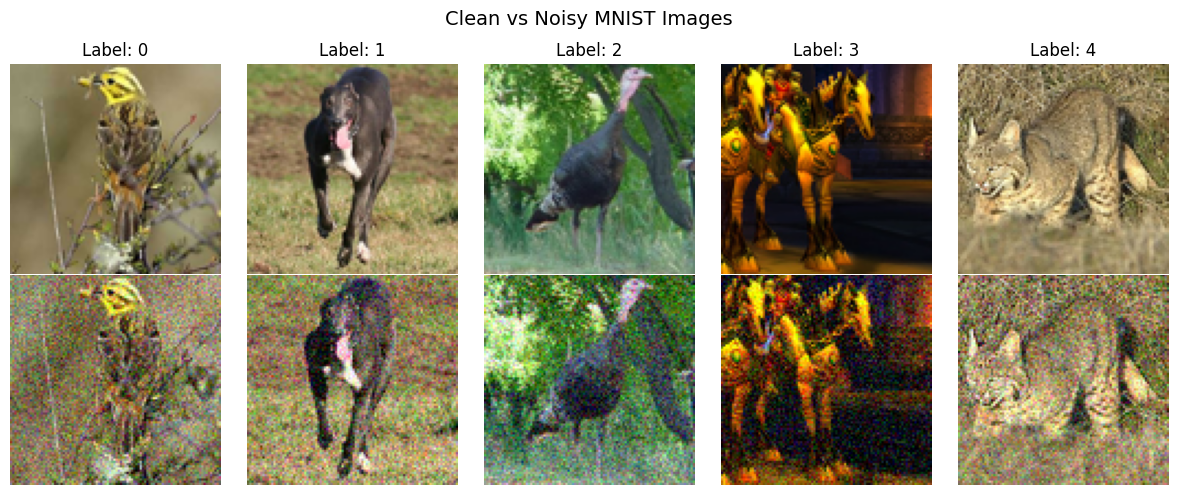

In [7]:
# Visualize some examples to see the effect
plt.figure(figsize=(12, 5))
for i in range(5):
    # Clean image
    plt.subplot(2, 5, i+1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    if i == 0: plt.ylabel('Clean', fontsize=12)
    plt.title(f'Label: {i}')
    plt.axis('off')

    # Noisy image
    plt.subplot(2, 5, i+6)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    if i == 0: plt.ylabel('Noisy', fontsize=12)
    plt.axis('off')

plt.suptitle('Clean vs Noisy MNIST Images', fontsize=14)
plt.tight_layout()
plt.show()

In [8]:
from tensorflow.keras import layers, Model

def build_fast_unet():
    inputs = layers.Input((96, 96, 3))

    # ENCODER
    c1 = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    p1 = layers.MaxPooling2D(2)(c1)   # 48x48

    c2 = layers.Conv2D(64, 3, activation="relu", padding="same")(p1)
    p2 = layers.MaxPooling2D(2)(c2)   # 24x24

    c3 = layers.Conv2D(128, 3, activation="relu", padding="same")(p2)
    p3 = layers.MaxPooling2D(2)(c3)   # 12x12

    # Bottleneck
    b = layers.Conv2D(128, 3, activation="relu", padding="same")(p3)

    # DECODER
    u1 = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(b)  # 24x24
    u1 = layers.Concatenate()([u1, c3])
    u1 = layers.Conv2D(128, 3, activation="relu", padding="same")(u1)

    u2 = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(u1)  # 48x48
    u2 = layers.Concatenate()([u2, c2])
    u2 = layers.Conv2D(64, 3, activation="relu", padding="same")(u2)

    u3 = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(u2)  # 96x96
    u3 = layers.Concatenate()([u3, c1])
    u3 = layers.Conv2D(32, 3, activation="relu", padding="same")(u3)

    outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(u3)

    return Model(inputs, outputs)

model = build_fast_unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 96,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 48,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 48, 48,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 24, 24,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 24,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 12,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 12, 12,    │    147,584 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 24, 24,    │    147,584 │ conv2d_3[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 24, 24,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 24,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 48, 48,    │     73,792 │ conv2d_4[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 48, 48,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 48, 48,    │     73,792 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 96, 96,    │     18,464 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 96, 96,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 96, 96,    │     18,464 │ concatenate_2[0]

 Total params: 868,835 (3.31 MB)

 Trainable params: 868,835 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Cell 5: Compile the Model
# Use Adam optimizer and binary crossentropy loss as specified in paper
model.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=[]  # We only care about loss for this project
)

# build encoder-decoder with skips as shown above (U-Net)
# assume `model` is built and outputs in [0,1]

In [10]:
# Cell 6: Train the Model
import time

# Record start time
start_time = time.time()

# Train the model for 20 epochs as specified
print("🚀 Starting training for 20 epochs...")
print("⏱️ This will take about 1-2 minutes on GPU")

history = model.fit(
    x_train_noisy,  # Input: noisy images
    x_train,        # Target: clean images
    epochs=10,      # Train for 10 epochs
    batch_size=128,  # Process 128 images at a time
    shuffle=True,   # Shuffle data each epoch
    validation_data=(x_test_noisy, x_test),  # Use test set for validation
    verbose=1,      # Show progress bar
    # callbacks=[]  # We could add early stopping here, but 20 epochs is fine
)

# Calculate training time
elapsed_time = time.time() - start_time
print(f"\n✅ Training completed in {elapsed_time:.1f} seconds")
print(f"📊 Final validation loss: {history.history['val_loss'][-1]:.4f}")

# Save the trained model to your Google Drive
# First, mount your drive (uncomment the next two lines on first run):
# from google.colab import drive
# drive.mount('/content/drive')

# Save model (you can uncomment this after mounting drive):
# model.save('/content/drive/MyDrive/denoising_autoencoder.h5')
# print("💾 Model saved to Google Drive")


🚀 Starting training for 20 epochs...
⏱️ This will take about 1-2 minutes on GPU
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 56s 531ms/step - loss: 0.1590 - val_loss: 0.0535
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 217ms/step - loss: 0.0504 - val_loss: 0.0409
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - loss: 0.0404 - val_loss: 0.0375
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - loss: 0.0375 - val_loss: 0.0382
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - loss: 0.0366 - val_loss: 0.0384
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - loss: 0.0364 - val_loss: 0.0340
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.0340 - val_loss: 0.0372
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.0345 - val_loss: 0.0334
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - loss: 0.0331 - val_loss: 0.0324
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - loss: 0.0328 - val_loss: 0.0321

✅ Training completed in 186.8 seconds
📊 Final va

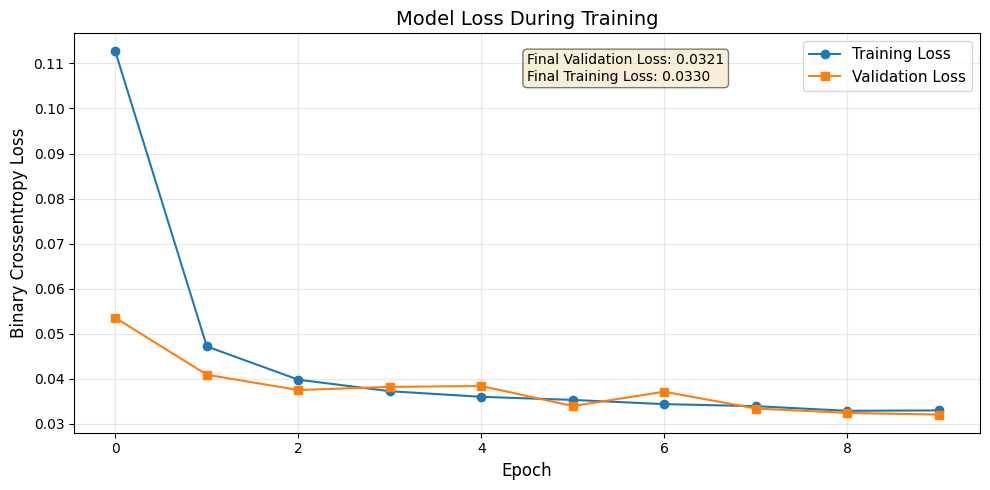


🎯 Target validation loss (from paper): 0.0871
📈 Your validation loss: 0.0321
✅ Excellent! Your model performed similarly to the research paper!


In [11]:
# Cell 7: Plot Training History
plt.figure(figsize=(10, 5))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')

plt.title('Model Loss During Training', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Binary Crossentropy Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add text box with final values
final_train = history.history['loss'][-1]
final_val = history.history['val_loss'][-1]
plt.text(0.5, 0.95, f'Final Validation Loss: {final_val:.4f}\nFinal Training Loss: {final_train:.4f}',
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\n🎯 Target validation loss (from paper): 0.0871")
print(f"📈 Your validation loss: {final_val:.4f}")
if final_val < 0.10:
    print("✅ Excellent! Your model performed similarly to the research paper!")
else:
    print("💡 Good effort! Try training for 5-10 more epochs or check your noise level")

🔮 Generating predictions on test set...
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step


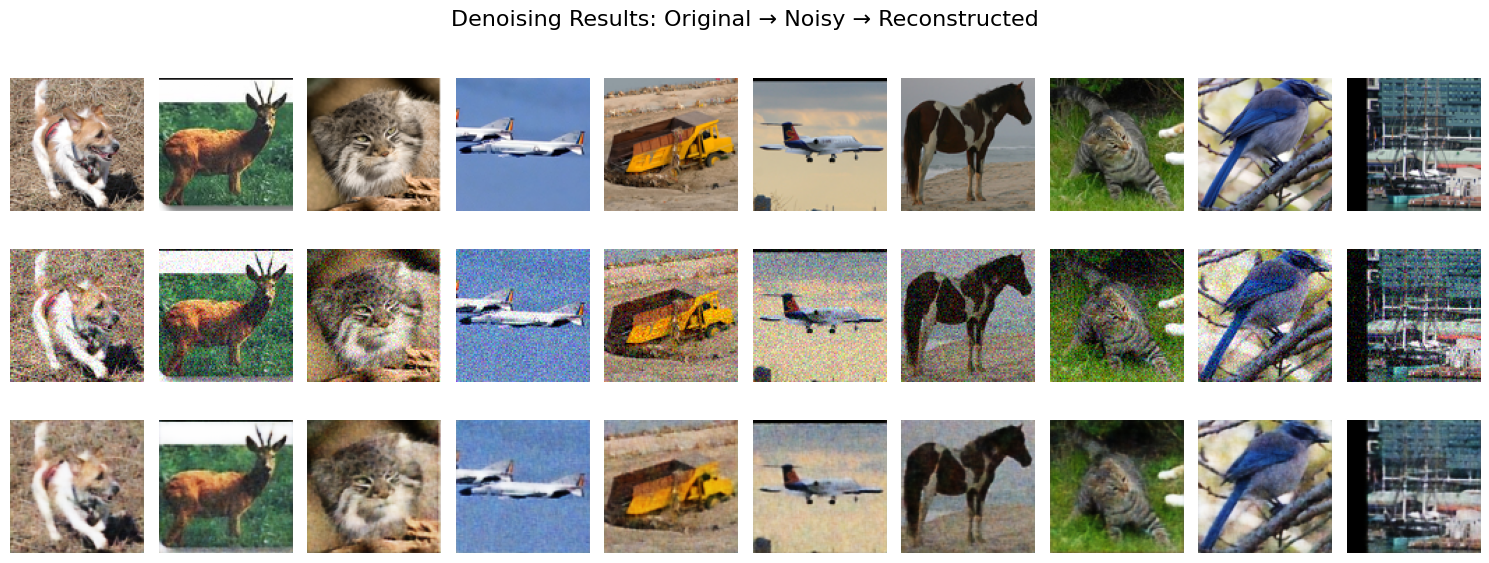


✅ Visualization complete! Compare the noisy vs denoised images.


In [12]:
# Cell 8: Test the Model and Visualize Results
# Use the trained model to denoise test images
print("🔮 Generating predictions on test set...")
denoised_images = model.predict(x_test_noisy, verbose=1)

# Create a comprehensive visualization
plt.figure(figsize=(15, 6))

# Select 10 random test images
np.random.seed(42)  # For reproducible visualization
indices = np.random.choice(len(x_test), 10, replace=False)

for i, idx in enumerate(indices):
    # Original clean image
    plt.subplot(3, 10, i+1)
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    if i == 0: plt.ylabel('Original', fontsize=12, labelpad=20)
    plt.axis('off')

    # Noisy image (input to model)
    plt.subplot(3, 10, i+11)
    plt.imshow(x_test_noisy[idx].squeeze(), cmap='gray')
    if i == 0: plt.ylabel('Noisy Input', fontsize=12, labelpad=20)
    plt.axis('off')

    # Denoised output (model prediction)
    plt.subplot(3, 10, i+21)
    plt.imshow(denoised_images[idx].squeeze(), cmap='gray')
    if i == 0: plt.ylabel('Denoised Output', fontsize=12, labelpad=20)
    plt.axis('off')

plt.suptitle('Denoising Results: Original → Noisy → Reconstructed',
             fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

print("\n✅ Visualization complete! Compare the noisy vs denoised images.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step


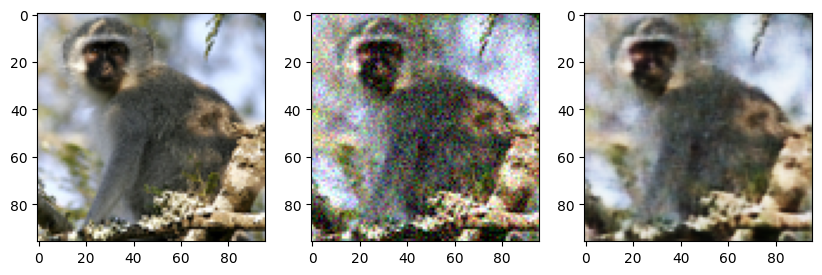

In [13]:
a = model.predict(np.expand_dims(x_test_noisy[90], axis=0))
plt.figure(figsize=(10,12))

plt.subplot(1,3,1)
plt.imshow(x_test[90])

plt.subplot(1,3,2)
plt.imshow(x_test_noisy[90])

plt.subplot(1,3,3)
plt.imshow(a[0])

In [14]:

model.save_weights("autoencoder_4.weights.h5")
print("Weights saved!")

Weights saved!
